# 이미지 식별 머신을 위한 데이터를 준비한다.

## 필요한 라이브러리를 불러 온다.

In [2]:
pip install torchvision


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install torch


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
# 데이터 플로팅 라이브러리
import matplotlib.pyplot as plt
# 숫자 처리 라이브러리
import numpy as np
# 딥러닝을 위한 파이토치 라이브러리
import torch
from torch import nn, optim
# 토치비전 라이브러리
import torchvision
from torchvision import datasets, transforms, models
# 이미지 처리 라이브러리 (PIL, pillow)
from PIL import Image
# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 디렉토리, 분할 비율, 변환 방법을 설정한다.

In [5]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 정한다.
data_dir = './data'
valid_size = 0.2

# 이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (t_transforms)
t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
])
# convert image size to 224x224 for ResNet50 after crop


### (확인) 변환 방법을 출력하여 확인해 본다.

In [6]:
# 설정한 이미지 데이터 변환 방법을 출력하여 확인한다.
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


## 데이터를 로딩 함수를 작성한다.

### (연습) trainloader와 testloader를 만들어 본다.

#### 1. 학습 데이터 세트 및 테스트 데이터 세트의 디렉토리 및 변환 방식을 지정한다.

In [7]:
# datasets.ImageFolder를 사용해서 학습 데이터(train_data)와 테스트 데이터(test_data)를 만든다.
# make train_data and test_data using datasets.ImageFolder
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

# 학습 데이터의 형식을 확인한다.
print(train_data)

# 학습 데이터와 테스트 데이터의 길이를 확인한다. 아직 분할 전이므로 둘 다 155개로 동일함.
print(len(train_data), len(test_data))



Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
155 155


#### 2. 데이터세트를 섞기 위해, 우선 인덱스를 만들어 랜덤하게 섞는다.

In [8]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
print(indices)



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[92, 64, 61, 77, 88, 79, 20, 72, 5, 94, 15, 87, 103, 22, 23, 52, 3, 41, 76, 145, 18, 138, 128, 86, 11, 93, 71, 13, 118, 67, 123, 116, 149, 53, 131, 101, 78, 104, 109, 44, 47, 147, 73, 46, 26, 75, 24, 36, 133, 31, 43, 57, 42, 144, 126, 45, 154, 56, 110, 98, 84, 100, 96, 82, 139, 34, 127, 119, 85, 102, 141, 120, 117, 7, 143, 0, 19, 4,

#### 3. 분할 비율(valid_size)에 따른 지점의 인덱스 값(split)을 계산한다.

In [9]:
# 분할 비율(valid_size=0.2)에 해당하는 인덱스를 계산하고 확인해 본다.
split = int(np.floor(num_train*valid_size))
print(split)

31


#### 4. split을 기준으로 학습 데이터 인덱스 리스트와 테스트 인덱스 리스트로 나눈다.

In [10]:
# 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)


[116, 149, 53, 131, 101, 78, 104, 109, 44, 47, 147, 73, 46, 26, 75, 24, 36, 133, 31, 43, 57, 42, 144, 126, 45, 154, 56, 110, 98, 84, 100, 96, 82, 139, 34, 127, 119, 85, 102, 141, 120, 117, 7, 143, 0, 19, 4, 59, 1, 8, 37, 146, 132, 124, 111, 90, 50, 2, 62, 17, 51, 95, 60, 35, 74, 121, 32, 136, 9, 63, 33, 16, 112, 122, 54, 30, 21, 113, 80, 137, 12, 105, 140, 58, 134, 68, 70, 152, 89, 151, 29, 150, 148, 10, 14, 107, 25, 130, 39, 66, 99, 153, 129, 81, 65, 91, 135, 115, 69, 49, 27, 125, 6, 114, 142, 83, 28, 40, 48, 97, 38, 55, 108, 106]
[92, 64, 61, 77, 88, 79, 20, 72, 5, 94, 15, 87, 103, 22, 23, 52, 3, 41, 76, 145, 18, 138, 128, 86, 11, 93, 71, 13, 118, 67, 123]


#### 5. 데이터 세트들의 샘플러 및 로더를 만들고 확인한다.

In [11]:
# 데이터 샘플링 방식(SubsetRandomSampler)을 지정한다
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# 데이터 로딩을 위한 loader를 만든다. (sampler, 배치 사이즈 등 지정)
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

# 학습 loader와 테스트 loader의 class들을 출력하여 확인한다.
print(trainloader.dataset.classes)
print(trainloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


### 코드들을 묶어서 load_split_train_test() 함수를 만든다.

In [12]:
# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)

def load_split_train_test(data_dir, valid_size):
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])  

    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train*valid_size))
    # 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
    train_idx, test_idx = indices[split:], indices[:split]

    from torch.utils.data.sampler import SubsetRandomSampler
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader    

### load_split_train_test() 함수를 이용하여 trainloader, testloader를 생성한다.

In [13]:
# load_split_train_test() 함수를 이용하여 trainloader와 testloader를 만들고 확인한다.
trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 이미지 데이터 샘플들을 살펴본다.

### 임의의 데이터를 로딩한 후 이미지와 레이블을 반환하는 get_random_images() 함수를 만든다.

In [14]:
def get_random_images(num):

    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)

    dataiter = iter(loader)
    images, labels = next(dataiter)

    return images, labels

### 임의 선택한 이미지를 표시해 본다.

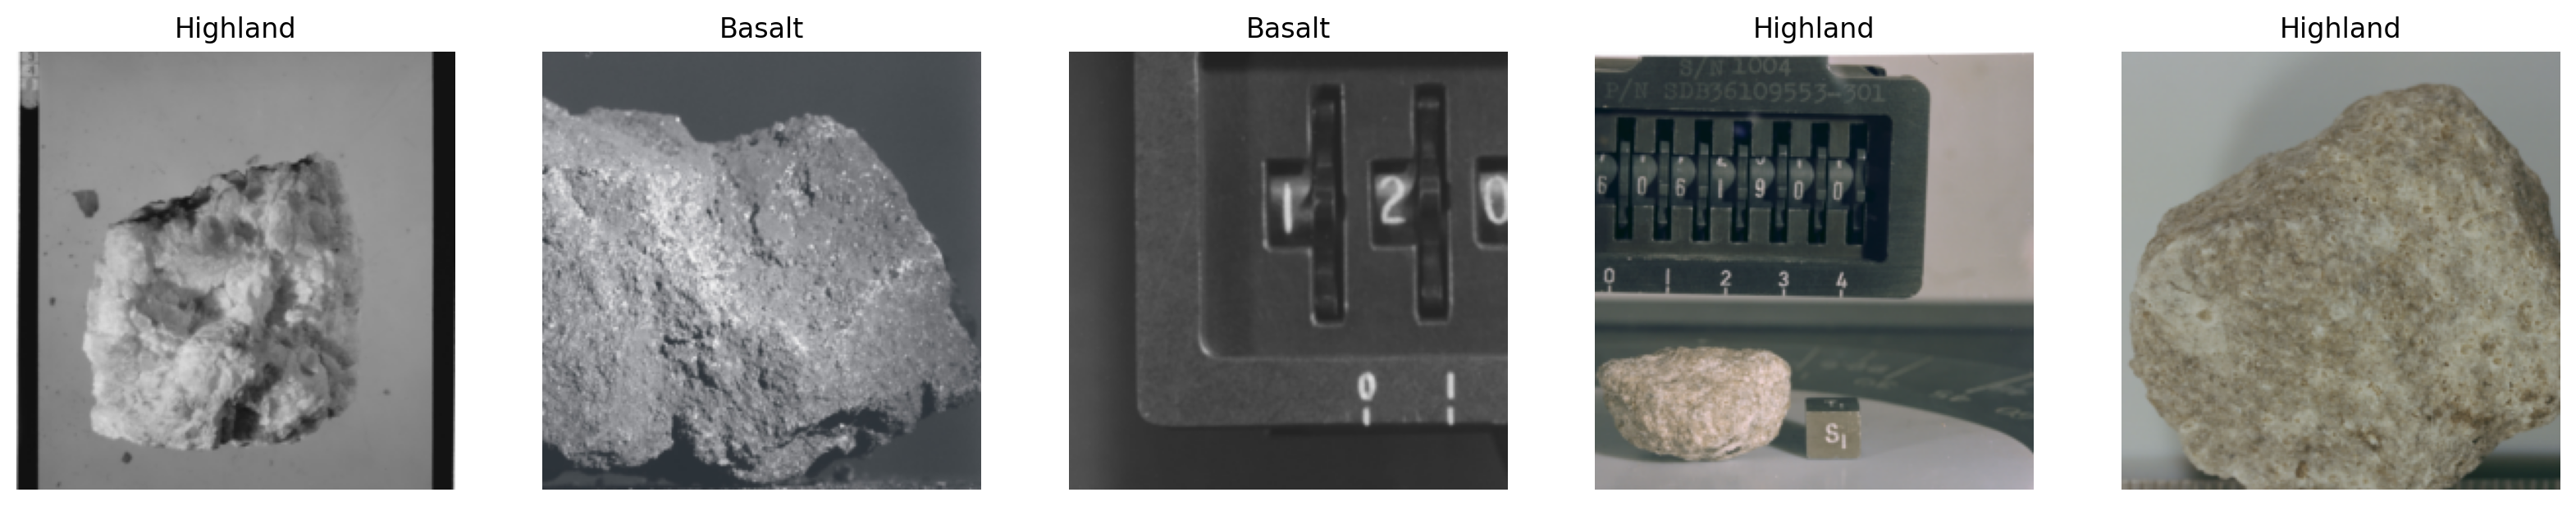

In [15]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))

# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes

# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images),ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)

# 주피터 노트북에 이미지를 표시한다.
plt.show()


# ResNet50 모델을 가져와 FCL(Fully Connected Layer)을 수정한다.

## Compute device를 정한다(CPU or GPU)

In [16]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## 사전학습된 ResNet50 모델을 지정한다.

In [17]:
# resnet50 모델을 pretrained=True로 설정한다.
model = models.resnet50(pretrained=True)


/usr/local/python/3.12.1/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/python/3.12.1/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### (확인) 수정 전의 ResNet50 모델을 확인해 본다. 

## FCL을 수정한다.(뉴런 구축, 신경망 연결, FCL의 layer 설정 등)

In [18]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    param.requires_grad = False
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                        nn.ReLU(), nn.Dropout(0.2), nn.Linear(512,2), nn.LogSoftmax(dim=1))
                        # q: explain the above code
                        # a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
                        # 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
                        # 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.
criterion = nn.NLLLoss()

# optimizer를 Adam으로 지정한다.
optimizer = optim.Adam(model.fc.parameters(),lr=0.003)

# 신경망을 compute device로 보낸다.
model.to(device)
# 종료 여부를 출력한다.
print('done!')


done!


### (확인) FCL을 확인해 본다.

In [19]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


# 모델의 FCL을 학습시키고 테스트 한다.

## 모델 학습/검증을 위한 변수를 설정한다.

In [20]:
# 에폭 및 출력 간격을 설정한다.
epochs = 10
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [],[]
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0


## 설정한 에폭만큼 모델을 학습시키며 검증/평가 한다.

In [21]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs):
    epoch += 1
    #trainloader 로부터 이미지와 레이블을 로드한다
    for inputs, labels in trainloader:
        # 학습 단계를 count 하고 출력한다
        steps += 1 
        print('Training step', steps)
        # 입력 데이터: 이미지 & 레이블을 device 로 보낸다
        inputs, labels = inputs.to(device), labels.to(device)
        # 기존에 학습된 gradient 값을 초기화해서 이전 학습값이 영향을 주지 않도록 한다
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다
        logps = model.forward(inputs)
        # 손실 값 계산
        loss = criterion(logps, labels)
        # 손실값을 이용하여 gradient update
        loss.backward()
        # gradient 를 이용하여 설정된 optimizeer 로 파라미터를 update
        optimizer.step()
        # 손실값을 누적/계산한다 
        running_loss += loss.item()


        if steps % print_every == 0:
            # 손실값과 정확도를 초기화
            test_loss = 0
            accuracy = 0
            
            # 모델 평가 모드로 전환
            model.eval()
            
            # 모델 평가 시 gradient를 업데이트하지 않도록 설정
            with torch.no_grad():
                # testloader로부터 모든 이미지와 레이블을 로드
                for inputs, labels in testloader:
                    # 입력 데이터(이미지, 레이블)를 device로 전송
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터를 순전파 실행하고 로그 확률 출력
                    logps = model.forward(inputs)
                    # 손실(오차) 값을 계산
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적
                    test_loss += batch_loss.item()
                    # 로그 확률을 실제 확률로 변환
                    ps = torch.exp(logps)
                    # 가장 큰 확률값을 얻음 (topk: k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블을 top_class와 동일한 형태로 변경
                    equals = top_class == labels.view(*top_class.shape)
                    # equals를 float 텐서로 변환 후 평균 정확도를 누적/계산
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # 학습 손실값과 테스트 손실값을 추가
            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))
            
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력
            print(f"Epoch {epoch+1}/{epochs}.. "
                f"Train loss: {running_loss/print_every:.3f}.. "
                f"Test loss: {test_loss/len(testloader):.3f}.. "
                f"Test accuracy: {accuracy/len(testloader):.3f}")
            
            # running_loss 초기화
            running_loss = 0
            
            # 모델 학습 모드로 전환
            model.train()
            break

Training step 1
Training step 2
Training step 3
Training step 4
Training step 5
Epoch 2/10.. Train loss: 1.507.. Test loss: 0.414.. Test accuracy: 0.835
Training step 6
Training step 7
Training step 8
Training step 9
Training step 10
Epoch 3/10.. Train loss: 0.539.. Test loss: 0.749.. Test accuracy: 0.713
Training step 11
Training step 12
Training step 13
Training step 14
Training step 15
Epoch 4/10.. Train loss: 0.811.. Test loss: 2.100.. Test accuracy: 0.292
Training step 16
Training step 17
Training step 18
Training step 19
Training step 20
Epoch 5/10.. Train loss: 1.053.. Test loss: 0.561.. Test accuracy: 0.771
Training step 21
Training step 22
Training step 23
Training step 24
Training step 25
Epoch 6/10.. Train loss: 0.461.. Test loss: 0.998.. Test accuracy: 0.479
Training step 26
Training step 27
Training step 28
Training step 29
Training step 30
Epoch 7/10.. Train loss: 0.622.. Test loss: 0.319.. Test accuracy: 0.838
Training step 31
Training step 32
Training step 33
Training s

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인한다.

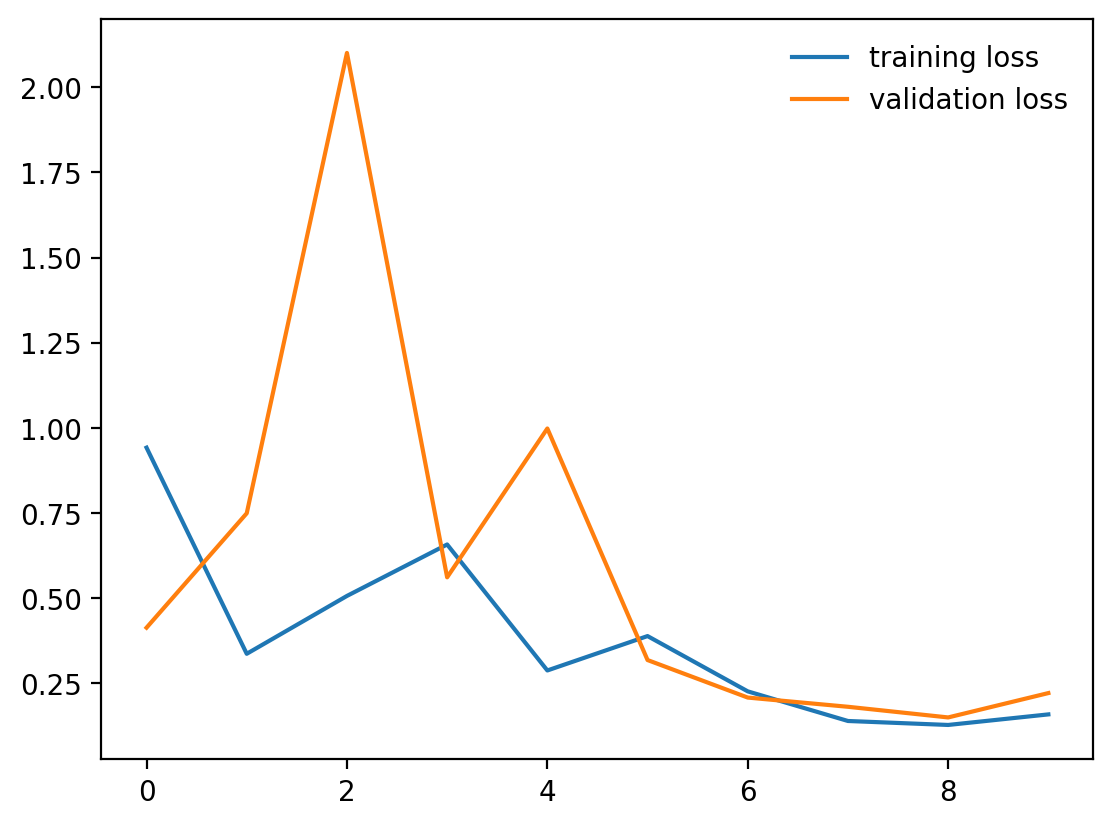

In [26]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'validation loss')
plt.legend(frameon=False)
# in this graph, what is x-axis? y-axis?
# x-axis: epoch
# y-axis: loss

# 학습/테스트 완료된 모델을 저장한다.

In [23]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model,'moonrockmodel.pth')

# 완성된 모델을 사용하여 예측한다.

## 저장한 모델을 불러온다.

In [24]:
# 저장한 모델을 불러온다.


### (확인) 불러온 모델을 확인해 본다.

## 이미지 예측을 위해 predict_image() 함수를 만든다.

## 5개의 이미지를 임의로 가져와 예측해 본다.